In [3]:
#                    imports
# ===========================================================================


!pip3 install timit-utils==0.9.0
!apt-get install sox ffmpeg libavutil-dev
!pip3 install torchaudio
! wget https://ndownloader.figshare.com/files/10256148 
!unzip -q 10256148
!mv data/lisa/data/timit/ data/timit/
!rm -rf data/lisa

!pip install numpy 
!pip install Cython
!pip install asteroid
!pip install -r voxceleb_trainer/requirements.txt

!rm -rf voxceleb_trainer
!git clone https://github.com/slotogram/voxceleb_trainer.git 

!find /content/data/timit/raw/TIMIT/TRAIN  -iname "*.wav" > voxceleb_trainer/train_all.txt

with open('voxceleb_trainer/train.txt', 'w') as fw:
  with open('voxceleb_trainer/train_all.txt', 'r') as f:
      for line in f:
        fw.write(line.split('/')[len(line.split('/'))-2:][0]+" " +line)

import timit_utils as tu
import librosa
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import torchaudio

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import IPython
_TIMIT_PATH = 'data/timit/raw/TIMIT'

%matplotlib inline
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du
import random

DATA_PATH = 'data/timit/raw/TIMIT'

import os
import random
from os import listdir
from os.path import isfile, join
random.seed(1)
torch.manual_seed(0)
np.random.seed(0)

with open('voxceleb_trainer/test.txt', 'w') as fw:
  for x in os.walk("/content/data/timit/raw/TIMIT/TEST/"):
    for y in os.walk(x[0]): 
      if y[0] != x[0]:
        subfolders = [ f.path for f in os.scandir(y[0]) if f.is_dir() ]
        for z in range(len(subfolders)):
          for root, dirs, files in os.walk(subfolders[z]):
            files = [ fi for fi in files if fi.endswith(".WAV") ]
            subfolders1 = subfolders.copy()
            subfolders1.remove(subfolders[z])

            for wav in range(len(files)): 
              #write legal 
              numbers = list(range(0, len(files)))
              numbers.remove(wav)
              rnd = random.choice(numbers)
              fw.write("1 "+subfolders[z]+ "/" +files[wav] + " " + subfolders[z]+ "/"+files[rnd]+ "\n")
              #write attacks
              rnd = random.randint(0, len(subfolders1)-1)
              att_files = [f for f in listdir(subfolders1[rnd]) if isfile(join(subfolders1[rnd], f))]
              att_files = [ fi for fi in att_files if fi.endswith(".WAV") ]
              rnd2 = random.randint(0, len(att_files)-1)
              fw.write("0 "+subfolders[z]+ "/" +files[wav] + " " + subfolders1[rnd]+ "/"+att_files[rnd2]+ "\n")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
libavutil-dev is already the newest version (7:3.4.11-0ubuntu0.1).
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-11-06 12:33:44--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 52.16.102.173, 54.217.124.219, 2a05:d018:1f4:d000:b283:27aa:b939:8ed4, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|52.16.102.173|:443... connected.
HTTP req

In [4]:
from IPython.display import Audio
import librosa
import librosa.display

from IPython.display import clear_output
!pip install audiomentations
clear_output()

!git clone https://github.com/slotogram/Audio_seminar.git

input_audio ="Audio_seminar/Natalie_Portman.wav"
clip, sample_rate = librosa.load(input_audio, sr=None)
display(Audio(clip, rate=sample_rate))

Cloning into 'Audio_seminar'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 4), reused 18 (delta 1), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [5]:
#                  adding noise  
# ===========================================================================

from audiomentations import AddBackgroundNoise

augment = AddBackgroundNoise(sounds_path="Audio_seminar/noise",min_snr_in_db=3.0,max_snr_in_db=5.0,p=1.0)

# Применяем аугментацию к аудио
augmented_data = augment(samples=clip, sample_rate=sample_rate)

display(Audio(augmented_data, rate=sample_rate))

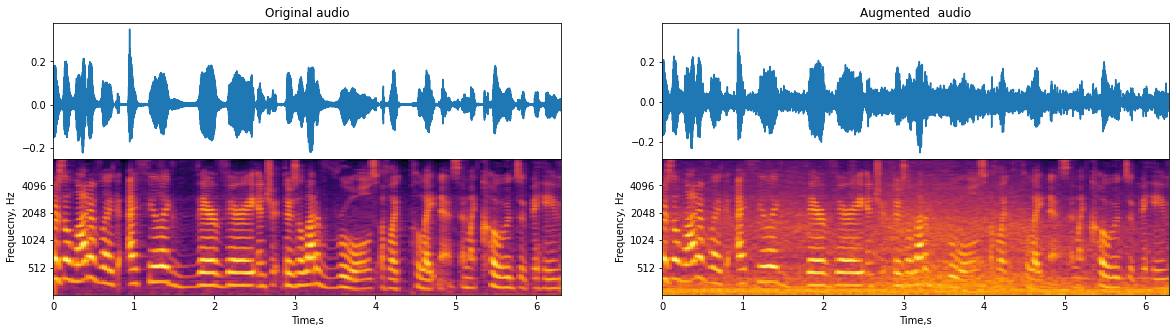

In [6]:
#        the difference between a normal signal and an augmented one
# ===========================================================================

def produce_plots(input_audio_arr, aug_audio, sr):
    sp1 = librosa.feature.melspectrogram(input_audio_arr, sr=sr, n_mels=128, fmin=20, fmax=8000)
    sp2 = librosa.feature.melspectrogram(aug_audio, sr=sr, n_mels=128, fmin=20, fmax=8000)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 5)) 

    ax[0,0].plot(input_audio_arr)
    ax[0,0].set_xlim(0, len(input_audio_arr))
    ax[0,0].set_xticks([])
    ax[0,0].set_title('Original audio')

    ax[0,1].plot(aug_audio)
    ax[0,1].set_xlim(0, len(input_audio_arr))
    ax[0,1].set_xticks([])
    ax[0,1].set_title('Augmented  audio')

    librosa.display.specshow(np.log(sp1), x_axis='time',  y_axis='mel', 
                         sr=sr,  fmin=20, fmax=8000, ax=ax[1,0],  cmap='inferno') #

    ax[1,0].set_ylabel('Frequecny, Hz')
    ax[1,0].set_xlabel('Time,s')
    
    librosa.display.specshow(np.log(sp2), x_axis='time',  y_axis='mel', 
                         sr=sr, fmin=20, fmax=8000, ax=ax[1,1],  cmap='inferno')
    ax[1,1].set_ylabel('Frequency, Hz')
    ax[1,1].set_xlabel('Time,s')

    plt.subplots_adjust(hspace=0)
    plt.show()

produce_plots(clip, augmented_data, sample_rate)

## Ускорение/замедление аудио (Time stretch)

In [7]:
from audiomentations import TimeStretch

augment = TimeStretch(min_rate=0.8, max_rate=1.5, p=1) 
augmented_data = augment(clip, sample_rate=sample_rate)

display(Audio(augmented_data, rate=sample_rate))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


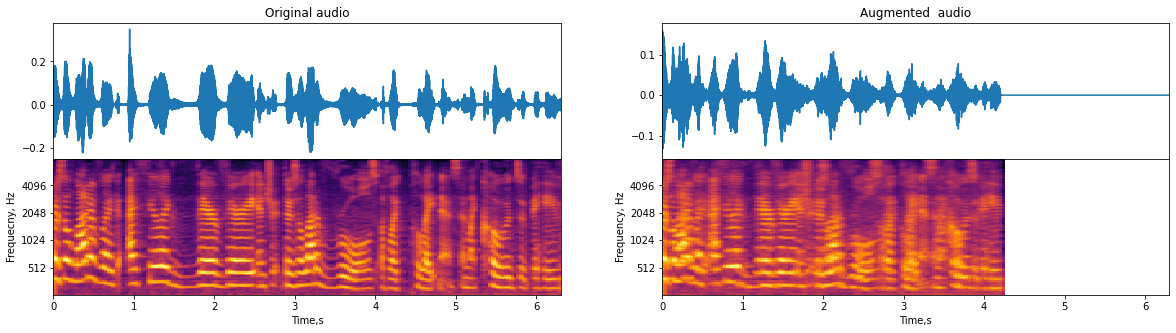

In [8]:
produce_plots(clip, augmented_data, sample_rate)

## Изменение тональности (Pitch Shift)

In [9]:
from audiomentations import PitchShift

augment = PitchShift(min_semitones=1, max_semitones=12, p=1)
augmented_data = augment(clip, sample_rate=sample_rate)

display(Audio(augmented_data, rate=sample_rate))

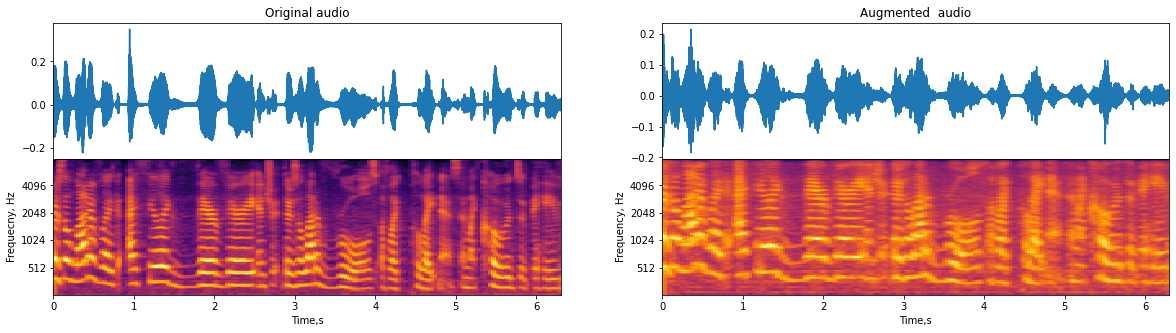

In [10]:
produce_plots(clip, augmented_data, sample_rate)

## Добавление реверберации

In [11]:
from audiomentations import ApplyImpulseResponse

augment = ApplyImpulseResponse(ir_path="Audio_seminar/ir", p=1)
augmented_data = augment(clip, sample_rate=sample_rate)

display(Audio(augmented_data, rate=sample_rate))

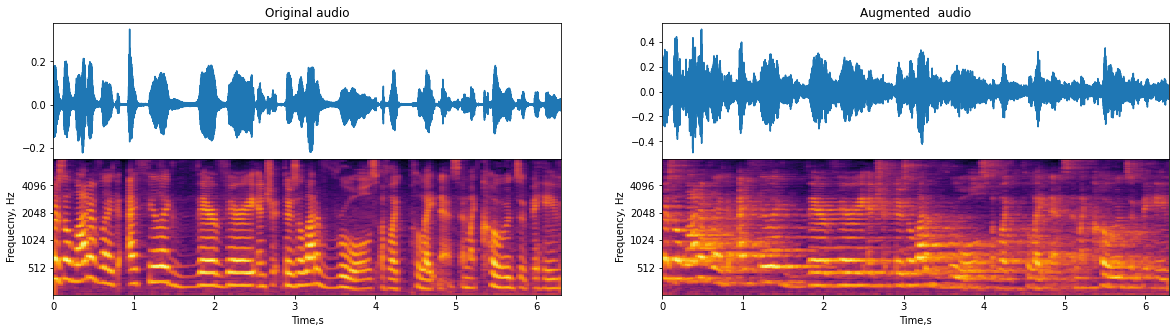

In [12]:
produce_plots(clip, augmented_data, sample_rate)

## Добавление нескольких типов аугментаций одновременно

In [13]:
from audiomentations import Compose

augment = Compose([
    AddBackgroundNoise(sounds_path="Audio_seminar/noise",min_snr_in_db=3.0,max_snr_in_db=5.0,p=1.0),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=1),
    PitchShift(min_semitones=-1, max_semitones=1, p=1),
    ApplyImpulseResponse(ir_path="Audio_seminar/ir", p=1)
])

augmented_data = augment(clip, sample_rate=sample_rate)
display(Audio(augmented_data, rate=sample_rate))

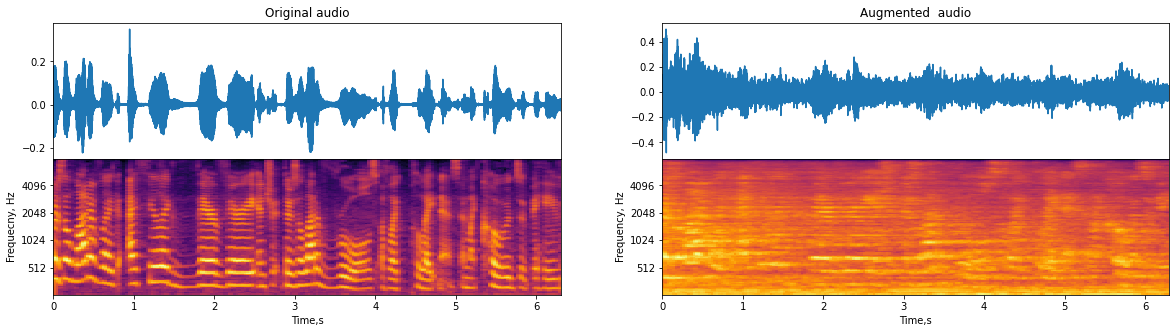

In [14]:
produce_plots(clip, augmented_data, sample_rate)